## IG聚合梯度方法
以下是一个简化的 Python 代码示例，展示如何用 PyTorch 计算 $f(x)$ 并分析 token 的重要性。我们假设有一个语言模型（比如 transformer），输入是一句话，输出是“好”与“坏”两个回答的概率。

In [2]:
import torch
import torch.nn.functional as F

# 假设的语言模型
class SimpleLanguageModel(torch.nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super().__init__()
        self.embedding = torch.nn.Embedding(vocab_size, embed_dim)
        self.linear = torch.nn.Linear(embed_dim, vocab_size)

    def forward(self, x, embeds_override=None):
        if embeds_override is None:
            embeds = self.embedding(x)
        else:
            embeds = embeds_override
        logits = self.linear(embeds)
        return logits, embeds

# =======================
# 初始化模型和输入
# =======================
vocab_size = 1000
embed_dim = 64
seq_length = 5
batch_size = 1

model = SimpleLanguageModel(vocab_size, embed_dim)
model.eval()

# 输入序列 x
x = torch.tensor([[10, 20, 30, 40, 50]], dtype=torch.long)

# 假设 y_pos 和 y_neg 是两个候选输出序列
y_pos = torch.tensor([[100, 101, 102]])
y_neg = torch.tensor([[200, 201, 202]])

# =======================
# 计算 log P(y | x)
# =======================
def compute_log_prob(model, x, y):
    """ 计算 log P(y|x)，这里简化为拼接 (x,y)，只在 y 部分算似然 """
    xy = torch.cat([x, y], dim=1)  # 拼接输入和目标
    logits, _ = model(xy)          # logits: [batch, seq_len, vocab_size]
    log_probs = F.log_softmax(logits, dim=-1)

    # 取出 y 部分的 log probs
    y_start = x.size(1)
    log_prob_y = 0.0
    for t in range(y.size(1)):
        token_id = y[0, t]
        log_prob_y += log_probs[0, y_start + t - 1, token_id]  # 用前一位预测当前 token

    return log_prob_y

# =======================
# 计算 f(x)
# =======================
log_prob_pos = compute_log_prob(model, x, y_pos)
log_prob_neg = compute_log_prob(model, x, y_neg)
f_x = log_prob_pos - log_prob_neg
print(f"f(x) = {f_x.item():.4f}")

# =======================
# 梯度归因：计算每个输入 token 的重要性
# =======================
# 对输入嵌入开启梯度
embeds = model.embedding(x).detach().requires_grad_(True)
logits, _ = model(x, embeds_override=embeds)
log_probs = F.log_softmax(logits, dim=-1)

# 重新计算 f(x)，但这里直接用定义 (1)
# 简化：只对最后一步预测 y_pos / y_neg 来算
log_prob_pos = log_probs[0, -1, y_pos[0, -1]]
log_prob_neg = log_probs[0, -1, y_neg[0, -1]]
f_x = log_prob_pos - log_prob_neg

# 反向传播
f_x.backward()

# 梯度重要性：||grad|| (L2 范数)
token_importance = embeds.grad.norm(dim=-1)
print("每个 token 的重要性：", token_importance.tolist())


f(x) = 0.2842
每个 token 的重要性： [[0.0, 0.0, 0.0, 0.0, 0.7183608412742615]]


## 构建引导向量

通过“对大量样本应用主成分分析（PCA）”，提取稳定的低维引导方向。具体而言，我们计算引导数据集$D$中每个delta集合的第一主成分，得到引导向量$v_l^+ \in \mathbb{R}^d$与$v_l^- \in \mathbb{R}^d$，如图2（B）所示：

$$\begin{align}
v_l^+ &= \text{PCA}_1\left(\{\delta_l^{+,(x)} : x \in D\}\right), \\
v_l^- &= \text{PCA}_1\left(\{\delta_l^{-,(x)} : x \in D\}\right). \tag{5}
\end{align}$$

tensor([-0.0172,  0.2516])


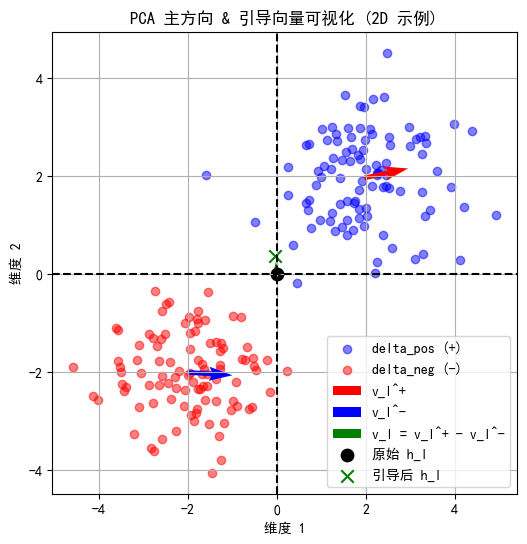

In [18]:
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 设置随机种子保证可复现
torch.manual_seed(42)

# 模拟 2D delta 向量（方便可视化）
# 列表 100个torch.size(2,)向量
delta_pos = [torch.randn(2) + torch.tensor([2.0, 2.0]) for _ in range(100)]  # 偏正方向
delta_neg = [torch.randn(2) + torch.tensor([-2.0, -2.0]) for _ in range(100)]  # 偏负方向

#通过stack堆叠后，变成(100,2)的torch张量，最后转为numpy数组
delta_pos_np = torch.stack(delta_pos).numpy()
delta_neg_np = torch.stack(delta_neg).numpy()

# PCA 提取第一主成分
pca_pos = PCA(n_components=1).fit(delta_pos_np)
pca_neg = PCA(n_components=1).fit(delta_neg_np)

v_pos = torch.tensor(pca_pos.components_[0], dtype=torch.float32)  # v_l^+
v_neg = torch.tensor(pca_neg.components_[0], dtype=torch.float32)  # v_l^-

# 相当于 一边踩刹车（抑制坏方向），一边踩油门（强化好方向）
v = v_pos - v_neg  # 最终对比引导向量

# 随机一个隐藏状态 h_l
h_l = torch.tensor([0.0, 0.0])  # 从原点开始
alpha = 1.5
h_l_guided = h_l + alpha * v

# ----------------- 可视化 -----------------
plt.figure(figsize=(6, 6))

plt.rcParams["font.sans-serif"]=["SimHei"] #设置字体
plt.rcParams["axes.unicode_minus"]=False #该语句解决图像中的“-”负号的乱码问题
# 绘制正负样本分布
# 所有行，第一列就是 x
# 所有行，第二列就是 y
plt.scatter(delta_pos_np[:, 0], delta_pos_np[:, 1], color='blue', alpha=0.5, label='delta_pos (+)')
plt.scatter(delta_neg_np[:, 0], delta_neg_np[:, 1], color='red', alpha=0.5, label='delta_neg (-)')

# 绘制 PCA 主方向（从均值点出发）
mean_pos = delta_pos_np.mean(axis=0)
mean_neg = delta_neg_np.mean(axis=0)

# 绘制引导向量 v_l +,- 箭头
# （从正方向的均值点出发）指向PCA提取出来正方向的箭头
plt.quiver(mean_pos[0], mean_pos[1], v_pos[0], v_pos[1], 
           angles='xy', scale_units='xy', scale=1, color='red', width=0.01, label='v_l^+')
plt.quiver(mean_neg[0], mean_neg[1], v_neg[0], v_neg[1], 
           angles='xy', scale_units='xy', scale=1, color='blue', width=0.01, label='v_l^-')

# 绘制最终引导向量 v_l（从原点出发）
plt.quiver(h_l[0], h_l[1], v[0], v[1], angles='xy', scale_units='xy', scale=1, 
           color='green', width=0.01, label='v_l = v_l^+ - v_l^-')
print(v)
# 显示引导前后的激活点
plt.scatter(h_l[0], h_l[1], color='black', s=80, label='原始 h_l')
plt.scatter(h_l_guided[0], h_l_guided[1], color='green', s=80, marker='x', label='引导后 h_l')

# 绘制一条水平参考线（horizontal line）
plt.axhline(0, color='black', linestyle='--', linewidth=1.5)
# 绘制一条垂直参考线（vertical line）
plt.axvline(0, color='black', linestyle='--', linewidth=1.5)

plt.legend()
plt.title("PCA 主方向 & 引导向量可视化 (2D 示例)")
plt.xlabel("维度 1")
plt.ylabel("维度 2")
plt.grid(True)
plt.show()


## FairSteer

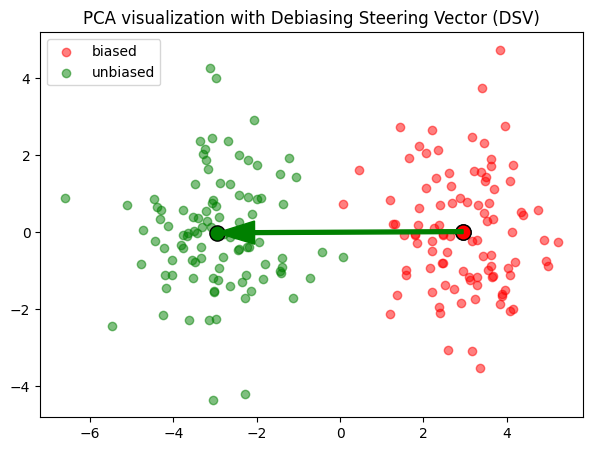

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 生成模拟数据：有偏（红色）和无偏（绿色）
np.random.seed(42)
biased = np.random.randn(100, 50) + np.array([3] + [0]*49)   # 在高维空间某个方向偏移
unbiased = np.random.randn(100, 50) + np.array([-3] + [0]*49)

# PCA降维到2D
# 创建一个PCA对象，设置目标维度为2（即降维到2D）
pca = PCA(n_components=2)
all_data = np.vstack([biased, unbiased])
# all_data.shape (200,50)
# fit：计算数据的主成分（找到方差最大的两个方向）
# 将原始50维数据投影到这两个主成分构成的2D空间
X_2d = pca.fit_transform(all_data)

# 取出降维后的数据
biased_2d = X_2d[:100]
unbiased_2d = X_2d[100:]

# 计算均值
mean_biased = biased_2d.mean(axis=0)
mean_unbiased = unbiased_2d.mean(axis=0)

# 箭头向量（DSV）
dsv = mean_unbiased - mean_biased

# 绘图
plt.figure(figsize=(7,5))
# 所有行第0列，所有行第1列 对应x,y坐标
plt.scatter(biased_2d[:,0], biased_2d[:,1], c='red', alpha=0.5, label='biased')
plt.scatter(unbiased_2d[:,0], unbiased_2d[:,1], c='green', alpha=0.5, label='unbiased')

# 画均值点和箭头
# 解包列表返回列表元素，得到x,y坐标
plt.scatter(*mean_biased, c='red', edgecolor='k', s=120)
plt.scatter(*mean_unbiased, c='green', edgecolor='k', s=120)
plt.arrow(mean_biased[0], mean_biased[1], dsv[0], dsv[1],
          color='green', width=0.1, head_width=0.6, length_includes_head=True)

plt.legend()
plt.title("PCA visualization with Debiasing Steering Vector (DSV)")
plt.show()
